In [1]:
# Import necessary libraries
import os
import sys
import argparse
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from model import CombinedModel    
from datasets import get_data_loaders, compute_mean_and_std, visualize_one_batch
from train import train
# from test import evaluate, load_model

# from tensorboard_utils import setup_tensorboard

In [2]:
def parse_args():
    parser = argparse.ArgumentParser(description='Training script')
    parser.add_argument('--learning_rate', type=float, default=1e-3, help='Learning rate for the optimizer')
    parser.add_argument('--checkpoint_dir', type=str, default='./checkpoints', help='Directory to save checkpoints')
    parser.add_argument('--log_dir', type=str, default='./logs', help='Directory for TensorBoard logs')
    parser.add_argument('--train_dir', type=str, default='D:/sp_cup/dataset/train', help='Directory for training data')
    parser.add_argument('--test_dir', type=str, default='D:/sp_cup/dataset//valid', help='Directory for testing data')
    parser.add_argument('--batch_size', type=int, default=16, help='Batch size for training')
    parser.add_argument('--epochs', type=int, default=2, help='Number of epochs to train')
    
    # Use parse_known_args to avoid errors
    args, unknown = parser.parse_known_args()
    return args


args = parse_args()

os.makedirs(args.checkpoint_dir, exist_ok=True)
os.makedirs(args.log_dir, exist_ok=True)

print(args)


Namespace(learning_rate=0.001, checkpoint_dir='./checkpoints', log_dir='./logs', train_dir='D:/sp_cup/dataset/train', test_dir='D:/sp_cup/dataset//valid', batch_size=16, epochs=2)


In [3]:
# Setup TensorBoard
# writer = setup_tensorboard(args.log_dir)

### Initialize Model

In [3]:
# Initialize model
print("Initializing Model")
model = CombinedModel()

"""model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_features = model.fc.in_features  # Get the number of features from the current fc layer
model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1), # Output layer for binary classification (Fake/Real)
    nn.Sigmoid()
)"""

print(model)

Initializing Model
CombinedModel(
  (freq_branch): FrequencyBranch(
    (fc1): Linear(in_features=98304, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=128, bias=True)
    (relu): ReLU()
  )
  (conv_branch): ConvBranch(
    (model): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (6): Dropout(p=0.3, inplace=False)
      )
      (1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2):

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")
model = model.to(device)

device: cuda


### Loss Function and Optimizer

In [6]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

### Image Preprocessing

In [7]:
# Load datasets

dataset_mean, dataset_std = compute_mean_and_std(args.train_dir)
print(f"Mean: {dataset_mean}, Std: {dataset_std}")

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean.tolist(), dataset_std.tolist())
])

train_loader, valid_loader = get_data_loaders(args.train_dir, args.test_dir, args.batch_size, transform)

Reusing cached mean and std
Mean: tensor([0.4578, 0.3924, 0.3772]), Std: tensor([0.2650, 0.2399, 0.2503])


c:\Users\hewaj\Desktop\Projects\Deepfake-Face-Detection-In-The-Wild\Deepfake Detection with FT\src\datasets.py:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.lo

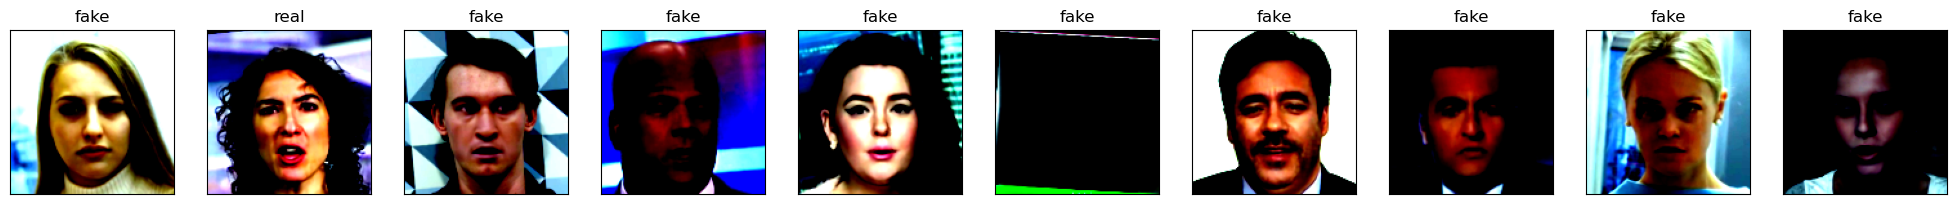

In [8]:
visualize_one_batch(train_loader)

### Train Model

In [9]:
# Train the model
print("Start Training")
train(model, train_loader, criterion, optimizer, args.epochs, args.checkpoint_dir)

Start Training


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16385 [00:00<?, ?it/s]

Epoch [1/2], Batch [1/16385], Loss: 0.6947
Epoch [1/2], Batch [51/16385], Loss: 31.2500


KeyboardInterrupt: 

### Load Model

In [ ]:
loaded_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Modify the fully connected layer to match the saved model
num_features = loaded_model.fc.in_features
loaded_model.fc = nn.Sequential(
	nn.Linear(num_features, 512),
	nn.ReLU(),
	nn.Dropout(0.5),
	nn.Linear(512, 1),
	nn.Sigmoid()
)

MODEL_SAVE_PATH = args.checkpoint_dir + '/final_checkpoint.pth'
state_dict = torch.load(MODEL_SAVE_PATH)

loaded_model.load_state_dict(state_dict)
loaded_model = loaded_model.to(device)
print(f"Model loaded from {MODEL_SAVE_PATH}")

In [ ]:
# Set both models to evaluation mode
model.eval()
loaded_model.eval()

# Compare the state dictionaries
def compare_models(model1, model2):
    model1_dict = model1.state_dict()
    model2_dict = model2.state_dict()
    
    for key in model1_dict:
        if not torch.equal(model1_dict[key], model2_dict[key]):
            return False
    return True

# Check if the parameters are identical
are_identical = compare_models(model, loaded_model)
print(f"Are the trained model and loaded model parameters identical? {are_identical}")

In [ ]:
#checkpoint_path = os.path.join(args.checkpoint_dir, 'final_checkpoint.pth')
#print(f"Loading model from {checkpoint_path}")
#model = load_model(checkpoint_path, model)

evaluate(loaded_model, valid_loader)